# 1 Import packages and define useful functions

The purpose of this notebook is to conduct further ML studies into the financial ratios / predictive power on stock market returns. Specifically, we will be looking at:
- whether drilling down into specific sectors improves the quality of prediction
- whether reformulating the problem as a clustering (+ve or -ve returns) one instead of regression leads to better prediction out of sample. 

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

import plotly.express as px
import matplotlib.pyplot as plt
import yfinance as yf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import RegressorChain
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
def convert_placeholder_text_to_num(text):
    '''
    Parsing helper script. In a lot of investing.com data e.g.6.1 M is used to indicate 6.1 million. This script converts the string 
    into float for machine learning to be carried out. 
    '''
    result = text
    try:
        if text[-1] == 'M':
            result = float(text[:-2]) * 10**6
        elif text[-1] == 'B':
            result = float(text[:-2]) * 10**9
        elif text[-1] == 'K':
            result = float(text[:-2]) * 10**3
        elif text[-1] == '-':
            result = np.nan
        elif text[-1] == 'nan':
            result = np.nan
        elif text[-1] == 'NA':
            result = np.nan
        elif text[-1] == 'x':
            result = float(text[:-1])
        elif text[-1] == '%':
            result = text.replace(",","")
            result = float(result[:-1])*0.01
    except Exception as e:
        print(e)
       
    return result

In [3]:
# import datasets

EV = pd.read_csv('data/ratios/EV.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')
fcf = pd.read_csv('data/ratios/fcf.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')
ebitda = pd.read_csv('data/ratios/ebitda.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')
revenue = pd.read_csv('data/ratios/revenue.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')
roe = pd.read_csv('data/ratios/roe.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')
gross_profit_margin = pd.read_csv('data/ratios/gross-profit-margin.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')
quick_ratio = pd.read_csv('data/ratios/quick-ratio.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')
debt_to_equity = pd.read_csv('data/ratios/debt-to-equity.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')

# remove duplicates
EV = EV.drop_duplicates()
fcf = fcf.drop_duplicates()
ebitda = ebitda.drop_duplicates()
revenue = revenue.drop_duplicates()
roe = roe.drop_duplicates()
gross_profit_margin = gross_profit_margin.drop_duplicates()
quick_ratio = quick_ratio.drop_duplicates()
debt_to_equity = debt_to_equity.drop_duplicates()

# set up for merging dataframes
EV = EV.reset_index()
fcf = fcf.reset_index()
ebitda = ebitda.reset_index()
revenue = revenue.reset_index()
roe = roe.reset_index()
gross_profit_margin = gross_profit_margin.reset_index()
quick_ratio = quick_ratio.reset_index()
debt_to_equity = debt_to_equity.reset_index()

EV = EV.astype(str)
fcf = fcf.astype(str)
ebitda = ebitda.astype(str)
revenue = revenue.astype(str)
roe = roe.astype(str)
gross_profit_margin = gross_profit_margin.astype(str)
quick_ratio = quick_ratio.astype(str)
debt_to_equity = debt_to_equity.astype(str)

In [4]:
# merge dataframes into one big one

dataframes = [fcf,ebitda,revenue,roe,gross_profit_margin,quick_ratio,debt_to_equity]
test_merge = EV

for elem in dataframes:
    test_merge = pd.merge(test_merge, elem, how = 'outer',
                      left_on=['Ticker','Name','Sector','Industry','Industry Group','Market Cap','Last Reported Fiscal Year'],
                      right_on=['Ticker','Name','Sector','Industry','Industry Group','Market Cap','Last Reported Fiscal Year'])
    
    
    
#test_merge = pd.merge(EV.reset_index(), fcf.reset_index(), how = 'inner',
                      #left_on=['Ticker','Name','Sector','Industry','Industry Group','Market Cap','Last Reported Fiscal Year'],
                      #right_on=['Ticker','Name','Sector','Industry','Industry Group','Market Cap','Last Reported Fiscal Year'])

In [5]:
# import historical assets

test_assets = pd.read_pickle('data/price_data_complete.pickle')
asset_prices = test_assets['Adj Close'].dropna(axis=1)
asset_prices = asset_prices.resample('Q').last()
asset_prices = asset_prices.iloc[:-1] # drop the last quarter
asset_prices = asset_prices.iloc[::-1] # reverse the order to be consistent with other financial data

In [6]:
asset_prices.head()

,1000.HK,1003.HK,1010.HK,1020.HK,1023.HK,1029.HK,1030.HK,1033.HK,1038.HK,1044.HK,...,8300.HK,8328.HK,8360.HK,8365.HK,8370.HK,8395.HK,8446.HK,8460.HK,8480.HK,9900.HK
Date,,,,,,,,,,,,,,,,,,,,,
2022-12-31,0.465,1.10,1.02,0.098,0.580000,0.133,2.89,0.510,40.849998,41.450001,...,0.019,5.17,0.93,0.88,0.068,0.83,8.80,0.21,0.240,0.84
2022-09-30,0.500,1.04,0.71,0.105,0.477632,0.115,1.84,0.455,39.449036,34.325504,...,0.019,4.47,0.90,0.38,0.139,0.75,8.80,0.21,0.230,1.20
2022-06-30,0.600,1.29,0.65,0.136,0.410088,0.198,3.88,0.610,47.378242,36.036888,...,0.026,6.80,0.93,0.74,0.200,0.90,4.88,0.35,0.220,1.62
2022-03-31,0.650,1.32,2.00,0.135,0.448684,0.210,4.22,0.640,49.940872,34.606182,...,0.027,4.00,0.40,0.71,0.223,0.93,1.94,0.23,0.205,2.00
2021-12-31,0.700,1.41,5.70,0.138,0.471812,0.226,5.27,0.650,47.274822,38.382275,...,0.036,4.00,0.47,0.52,0.325,0.87,0.32,0.34,0.270,2.00


In [7]:
ML_data = test_merge.applymap(convert_placeholder_text_to_num);

'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscriptable
'float' object is not subscr

In [21]:
ML_data.head()

,Ticker,Name,Sector,Industry,Industry Group,Market Cap,Last Reported Fiscal Year,EV,EV FQ-1,EV FQ-2,...,Debt / Equity FQ-3,Debt / Equity FQ-4,Debt / Equity FQ-5,Debt / Equity FQ-6,Debt / Equity FQ-7,Debt / Equity FQ-8,Debt / Equity FQ-9,Debt / Equity FQ-10,Debt / Equity FQ-11,Debt / Equity FQ-12
0,199,ITC Properties Group Limited,Real Estate,Real Estate Management & Development,Real Estate,1.221000e+08,2023,4.833800e+07,75623000.0,101000000.0,...,0.515,0.899,0.899,0.773,0.773,0.836,0.836,0.839,0.839,0.847
1,2322,Hong Kong ChaoShang Group Limited,Industrials,Trading Companies & Distributors,Capital Goods,3.832000e+08,2023,3.652000e+08,438800000.0,409700000.0,...,0.015,0.007,0.007,0.021,0.021,0.028,0.028,0.037,0.037,0.044
2,83,Sino Land Company Limited,Real Estate,Real Estate Management & Development,Real Estate,1.100900e+10,2023,3.163000e+09,2236000000.0,3878000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,321,Texwinca Holdings Limited,Consumer Discretionary,"Textiles, Apparel & Luxury Goods",Consumer Durables & Apparel,2.464000e+08,2023,1.476000e+08,178700000.0,173300000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,335,Upbest Group Limited,Financials,Consumer Finance,Diversified Financials,2.050000e+08,2023,NaN,nan,nan,...,0.086,0.094,0.094,0.099,0.099,0.104,0.104,0.108,0.108,0.112


In [8]:
ratio_ticker_list = list(ML_data.Ticker)
ratio_ticker_list_new = []

for elem in ratio_ticker_list:
    ratio_ticker_list_new.append(elem+'.HK')

asset_ticker_list = list(asset_prices.columns)

combined_tickers = [value for value in asset_ticker_list if value in ratio_ticker_list_new]

combined_tickers
combined_ticker_int = []

for elem in combined_tickers:
    combined_ticker_int.append(elem[:-3])

ML_final = ML_data[ML_data['Ticker'].isin(combined_ticker_int)]

def convert_ticker_to_str(ticker):
    return str(ticker)+'.HK'

ML_final['Ticker'] = ML_final['Ticker'].map(convert_ticker_to_str)
ML_final = ML_final.drop_duplicates('Ticker')

asset_prices[combined_tickers].head()

/tmp/ipykernel_111803/3276006336.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ML_final['Ticker'] = ML_final['Ticker'].map(convert_ticker_to_str)


,1003.HK,1023.HK,1029.HK,1030.HK,1033.HK,1038.HK,1044.HK,1045.HK,1050.HK,1051.HK,...,8053.HK,8095.HK,8137.HK,8227.HK,8279.HK,8299.HK,8328.HK,8365.HK,8395.HK,8446.HK
Date,,,,,,,,,,,,,,,,,,,,,
2022-12-31,1.10,0.580000,0.133,2.89,0.510,40.849998,41.450001,2.110000,1.436471,2.1700,...,0.395000,0.56,0.345,0.49,0.248,0.164,5.17,0.88,0.83,8.80
2022-09-30,1.04,0.477632,0.115,1.84,0.455,39.449036,34.325504,1.925430,1.261765,1.6400,...,0.370380,0.47,0.285,0.50,0.290,0.250,4.47,0.38,0.75,8.80
2022-06-30,1.29,0.410088,0.198,3.88,0.610,47.378242,36.036888,1.901738,1.339136,2.2848,...,0.453228,0.56,0.305,0.62,0.305,0.300,6.80,0.74,0.90,4.88
2022-03-31,1.32,0.448684,0.210,4.22,0.640,49.940872,34.606182,2.124947,1.395720,2.5228,...,0.414241,0.60,0.285,0.68,0.320,0.039,4.00,0.71,0.93,1.94
2021-12-31,1.41,0.471812,0.226,5.27,0.650,47.274822,38.382275,2.035663,1.462407,2.6656,...,0.487342,0.52,0.360,1.37,0.285,0.040,4.00,0.52,0.87,0.32


In [42]:
pd.concat([pd.DataFrame(index=asset_prices[combined_tickers].pct_change(-1).iloc[:12,:].index).reset_index(),dfa.reset_index(drop=True)],axis=1)

,Date,13
0,2022-12-31,0.183935
1,2022-09-30,-0.203670
2,2022-06-30,0.415586
3,2022-03-31,-0.090339
4,2021-12-31,-0.411888
5,2021-09-30,0.535086
6,2021-06-30,0.663616
7,2021-03-31,-0.034274
8,2020-12-31,-0.389459
9,2020-09-30,0.020098


In [110]:
asset_prices[combined_tickers].pct_change(-1).iloc[:12,:]['1003.HK']

Date
2022-12-31    0.057692
2022-09-30   -0.193798
2022-06-30   -0.022727
2022-03-31   -0.063830
2021-12-31   -0.066225
2021-09-30   -0.161111
2021-06-30   -0.162791
2021-03-31    0.524823
2020-12-31    0.014388
2020-09-30   -0.085526
2020-06-30    0.070423
2020-03-31   -0.053333
Freq: -1Q-DEC, Name: 1003.HK, dtype: float64

In [131]:
def create_ML_dataframe(dataframe):
    '''
    Casts the financial ratios df + returns df into a format suitable for ML
    '''
    financial_ratios = ['EV','FCF','EBITDA','Revenue','ROE','Gross-Profit-Margin','Quick-Ratio','Debt / Equity']
    
    
    df = dataframe.copy()
    df = df.loc[:,df.columns.str.contains('Ticker|Sector|EV|FCF|EBITDA|Revenue|ROE|Gross-Profit-Margin|Quick-Ratio|Debt / Equity')]
    
    tickers = df.Ticker.values
    
    # output_df = pd.DataFrame(columns=['Date']+financial_ratios)
    output_df = pd.DataFrame()
    
    for ticker in tickers:
        dfa = pd.DataFrame(asset_prices[combined_tickers].pct_change(-1).iloc[:12,:].index)
    # pd.concat([pd.DataFrame(index=asset_prices[combined_tickers].pct_change(-1).iloc[:12,:].index).reset_index(),dfa.reset_index(drop=True)],axis=1)
        for FR in financial_ratios:            
            try:
                dfb = df.loc[df['Ticker'] == ticker, df.columns.str.contains(FR)].transpose().pct_change(-1).iloc[1:]
            except Exception as e:
                test_ind = [str(FR)+' FQ-'+str(x) for x in range(1,13)]
                dfb = pd.DataFrame(len(['FCF FQ-'+str(x) for x in range(1,13)]) * [np.NaN],index=test_ind)
                
                # see what the damage is, drop if there aren't too many
                # print(str(e)+' for '+str(FR)+' and '+str(ticker))
                
            dfa = pd.concat([dfa.reset_index(drop=True), dfb.reset_index(drop=True)],axis=1)
            

        
        dfa['Return'] = asset_prices[combined_tickers].pct_change(-1).iloc[:12,:][ticker].values
        dfa.columns = ['Date']+financial_ratios+['Return']
        # output_df = output_df.append(dfa.reset_index(), ignore_index=True)
        output_df = pd.concat([output_df,dfa.reset_index(drop=True)],axis=0)    
    
    return output_df

test = create_ML_dataframe(ML_final)
test

,Date,EV,FCF,EBITDA,Revenue,ROE,Gross-Profit-Margin,Quick-Ratio,Debt / Equity,Return
0,2022-12-31,0.071028,0.861272,4.184368,0.750943,0.000000,-0.350000,-0.234043,1.133333,-0.105882
1,2022-09-30,-0.117976,-0.004707,-0.004689,-0.004744,0.035714,0.000000,0.000000,0.000000,-0.044944
2,2022-06-30,0.023128,2.351211,-0.851314,-0.129709,0.000000,0.855670,0.305556,1.142857,0.059524
3,2022-03-31,-0.115871,-0.002620,-0.002887,-0.002574,0.037037,0.000000,0.000000,0.000000,-0.106383
4,2021-12-31,-0.004845,1.278169,1.185781,-0.401397,0.080000,-0.419162,0.180328,-0.666667,0.021739
...,...,...,...,...,...,...,...,...,...,...
7,2021-03-31,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,-0.033195
8,2020-12-31,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,-0.202025,0.040288
9,2020-09-30,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,-0.021127
10,2020-06-30,NaN,NaN,NaN,NaN,NaN,NaN,-0.333333,0.145739,0.005666


In [44]:
def create_ML_dataframe(dataframe):
    '''
    Casts the financial ratios df + returns df into a format suitable for ML
    '''
    financial_ratios = ['EV','FCF','EBITDA','Revenue','ROE','Gross-Profit-Margin','Quick-Ratio','Debt / Equity']
    
    
    df = dataframe.copy()
    df = df.loc[:,df.columns.str.contains('Ticker|Sector|EV|FCF|EBITDA|Revenue|ROE|Gross-Profit-Margin|Quick-Ratio|Debt / Equity')]
    
    tickers = df.Ticker.values
    
    #for ticker in tickers:
    dfa = pd.DataFrame(asset_prices[combined_tickers].pct_change(-1).iloc[:12,:].index)
    # pd.concat([pd.DataFrame(index=asset_prices[combined_tickers].pct_change(-1).iloc[:12,:].index).reset_index(),dfa.reset_index(drop=True)],axis=1)
    for FR in financial_ratios[1]:
        dfb = df.loc[df['Ticker'] == '1023.HK', df.columns.str.contains(FR)].transpose().pct_change(-1).iloc[1:]
        dfa = pd.concat([dfa.reset_index(drop=True), dfb.reset_index(drop=True)])   
    return df

create_ML_dataframe(ML_final)




test = ML_final.loc[:,ML_final.columns.str.contains('Ticker|Sector|EV|FCF|EBITDA|Revenue|ROE|Gross-Profit-Margin|Quick-Ratio|Debt / Equity')]

# things done: calculaet % change, then shift forward 1 time period to see if FR has any predictive power, finally, drop NaNs

dfa = test.loc[test['Ticker'] == '1023.HK',test.columns.str.contains('EV')].transpose().pct_change(-1).iloc[1:]
try:
    dfb = test.loc[test['Ticker'] == '1023.HK',test.columns.str.contains('FCF')].transpose().pct_change(-1).iloc[1:]
except Exception as e:
    # create a list with FR prefix: ['FCF FQ-'+str(x) for x in range(1,13)]
    # create a second list with the same length, but all with NaNs
    # create a dataframe from both
    # 
    # test_ind = ['FCF FQ-'+str(x) for x in range(1,13)]
    # pd.DataFrame(len(['FCF FQ-'+str(x) for x in range(1,13)]) * [np.NaN],index=test_ind)
    # 
    # see what the damage is, drop if there aren't too many
    print(e)
    dfb = pd.DataFrame()

pd.concat([dfa.reset_index(drop=True),dfb.reset_index(drop=True)],axis=1)

,13,13
0,0.183935,2.981746
1,-0.203670,-0.001585
2,0.415586,-1.477036
3,-0.090339,-0.001510
4,-0.411888,-2.050763
5,0.535086,0.001191
6,0.663616,2.665939
7,-0.034274,-0.000727
8,-0.389459,-0.261150
9,0.020098,0.000538


In [30]:
test = ML_final.loc[:,ML_final.columns.str.contains('Ticker|Sector|EV|FCF|EBITDA|Revenue|ROE|Gross-Profit-Margin|Quick-Ratio|Debt / Equity')]

# things done: calculaet % change, then shift forward 1 time period to see if FR has any predictive power, finally, drop NaNs

dfa = test.loc[test['Ticker'] == '1023.HK',test.columns.str.contains('EV')].transpose().pct_change(-1).iloc[1:]
try:
    dfb = test.loc[test['Ticker'] == '1023.HK',test.columns.str.contains('FCF')].transpose().pct_change(-1).iloc[1:]
except Exception as e:
    # create a list with FR prefix: ['FCF FQ-'+str(x) for x in range(1,13)]
    # create a second list with the same length, but all with NaNs
    # create a dataframe from both
    # 
    # test_ind = ['FCF FQ-'+str(x) for x in range(1,13)]
    # pd.DataFrame(len(['FCF FQ-'+str(x) for x in range(1,13)]) * [np.NaN],index=test_ind)
    # 
    # see what the damage is, drop if there aren't too many
    print(e)
    dfb = pd.DataFrame()

pd.concat([dfa.reset_index(drop=True),dfb.reset_index(drop=True)],axis=1)

,13,13
0,0.183935,2.981746
1,-0.203670,-0.001585
2,0.415586,-1.477036
3,-0.090339,-0.001510
4,-0.411888,-2.050763
5,0.535086,0.001191
6,0.663616,2.665939
7,-0.034274,-0.000727
8,-0.389459,-0.261150
9,0.020098,0.000538


In [22]:
test_ind = ['FCF FQ-'+str(x) for x in range(1,13)]
pd.DataFrame(len(['FCF FQ-'+str(x) for x in range(1,13)]) * [np.NaN],index=test_ind)

,0
FCF FQ-1,NaN
FCF FQ-2,NaN
FCF FQ-3,NaN
FCF FQ-4,NaN
FCF FQ-5,NaN
FCF FQ-6,NaN
FCF FQ-7,NaN
FCF FQ-8,NaN
FCF FQ-9,NaN
FCF FQ-10,NaN


In [ ]:
def get_train_test_from_fratio(fratio):
    '''
    Given a financial ratio (list below), return a dataframe [X1,X2,...,y1,y2,...] where Xi are the financial ratios and yi are the % returns for the asset.
    Vertical axis is time (in decreasing order)
    
    Financial ratios: 
    - EV
    - FCF
    - EBITDA
    - Revenue
    - ROE
    - Gross-Profit-Margin
    - Quick-Ratio
    - Debt / Equity
    '''
    
    EV_lhs = ML_final.loc[:,ML_final.columns.str.contains(fratio)].transpose().reset_index().rename(columns={1: '2322.HK', 13: '1023.HK',\
                                                                                             18: '1468.HK',20: '1243.HK',\
                                                                                             25: '1373.HK',57: '1140.HK',\
                                                                                             96: '1499.HK'})
    # reverse the order of the df, calculate % change i.e. returns, then select datapoints corresponding to financial ratios. 
    returns_rhs = asset_prices[::-1].pct_change(-1).iloc[:13].rename(columns={'2322.HK': '2322.HK ret', '1023.HK': '1023.HK ret',\
                                                                                                 '1468.HK': '1468.HK ret','1243.HK': '1243.HK ret',\
                                                                                                 '1373.HK': '1373.HK ret','1140.HK': '1140.HK ret',\
                                                                                                 '1499.HK': '1499.HK ret'})
    
    df = pd.concat([EV_lhs, returns_rhs.reset_index()],axis=1)[['Date','2322.HK','2322.HK','1023.HK','1468.HK','1243.HK','1373.HK',\
                                                       '1140.HK','1499.HK','2322.HK ret','1023.HK ret','1468.HK ret',\
                                                       '1243.HK ret','1373.HK ret','1140.HK ret','1499.HK ret']].set_index('Date')
    return df

In [79]:
def create_training_dataframe(dataframe):
    '''
    Take a ML dataframe that has been filtered according to sector and/or financial ratio.
    Get historical asset prices for the tickers present in the dataframe
    Combine the asset prices and then spit out the final dataframe which can be used directly in ML applications
    '''
    
    # get list of tickers from dataframe and cast them into the correct format for fetching historical prices
    ticker_list_to_fetch_for_ratios = list(dataframe.Ticker)
    ticker_list_to_fetch_for_ratios_new = []
    
    for elem in ticker_list_to_fetch_for_ratios:
        ticker_list_to_fetch_for_ratios_new.append(elem+'.HK')
    
    # get the complete list of tickers for which historical data is available
    asset_ticker_list = list(asset_prices.columns)
    
    # determine the intersection of tickers in the 'ratios' dataframe vs 'historical prices' dataframe
    
    combined_tickers = [value for value in asset_ticker_list if value in ticker_list_to_fetch_for_ratios_new]
    
    combined_ticker_int = []
    for elem in combined_tickers:
        combined_ticker_int.append(elem[:-3])
        
    ML_final = ML_data[ML_data['Ticker'].isin(combined_ticker_int)]
    
    return ML_final

In [ ]:
create_training_dataframe(

**To do**
- filter by sector
- dataframe lengths

In [81]:
def get_filtered_df(dataframe,sector,financial_ratio):
    '''
    Filter the dataframe for a given financial ratio and sector
    '''
    
    filtered_df = dataframe.loc[dataframe['Sector'] == sector]
    return filtered_df.loc[:,filtered_df.columns.str.contains(financial_ratio)]

In [82]:
get_filtered_df(test_merge,'Real Estate', 'EV')

,EV,EV FQ-1,EV FQ-2,EV FQ-3,EV FQ-4,EV FQ-5,EV FQ-6,EV FQ-7,EV FQ-8,EV FQ-9,EV FQ-10,EV FQ-11,EV FQ-12
0,48.338 M,75.623 M,101 M,103.8 M,82.451 M,157.3 M,222.7 M,122 M,140.1 M,147.1 M,161 M,130 M,154.2 M
2,3.163 B,2.236 B,3.878 B,2.304 B,1.834 B,2.401 B,4.238 B,2.748 B,1.867 B,522.3 M,1.384 B,1.213 B,2.629 B
7,12.229 B,10.462 B,9.692 B,9.649 B,9.495 B,9.391 B,12.079 B,12.092 B,9.649 B,9.622 B,8.791 B,8.541 B,10.427 B
9,511.3 M,592.7 M,537.9 M,731.3 M,538 M,552.5 M,622.6 M,653.9 M,491.7 M,353.9 M,367 M,382 M,426.8 M
10,389.8 M,496.9 M,536.1 M,543.3 M,569.6 M,608.2 M,596.4 M,596.2 M,598.5 M,658.8 M,716.9 M,806.6 M,957 M
...,...,...,...,...,...,...,...,...,...,...,...,...,...
888,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
def get_length_of_dataframe(dataframe, sector, financial_ratio):
    '''
    For a dataframe containing financial ratios, return the number of rows after all NaN's are dropped
    '''
    filtered_df = dataframe.loc[dataframe['Sector'] == sector]
    return len(filtered_df.loc[:,filtered_df.columns.str.contains(financial_ratio)].dropna())

In [26]:
get_length_of_dataframe(test_merge,'Real Estate', 'EV')

39

In [40]:
list_of_financial_ratio_strings = ['EV', 'FCF', 'EBITDA', 'Revenue', 'ROE', 'Gross-Profit-Margin', 'Quick-Ratio','Debt / Equity']
list_of_sectors = list(set(test_merge['Sector'].values))

In [49]:
df_length_mat = np.zeros([len(list_of_financial_ratio_strings),len(list_of_sectors)])
for i in range(len(list_of_financial_ratio_strings)):
    for j in range(len(list_of_sectors)):
        df_length_mat[i,j] = get_length_of_dataframe(test_merge,list_of_sectors[j],list_of_financial_ratio_strings[i])

In [67]:
test = pd.DataFrame(df_length_mat,columns=list_of_sectors,index=list_of_financial_ratio_strings)
test

,Utilities,Financials,Consumer Staples,Communication Services,Industrials,Healthcare,Energy,Real Estate,Consumer Discretionary,Information Technology,Materials
EV,5.0,38.0,21.0,10.0,43.0,19.0,5.0,39.0,59.0,13.0,10.0
FCF,29.0,85.0,39.0,37.0,120.0,55.0,19.0,108.0,139.0,48.0,55.0
EBITDA,33.0,70.0,40.0,34.0,119.0,51.0,17.0,111.0,138.0,44.0,59.0
Revenue,8.0,42.0,18.0,18.0,65.0,26.0,11.0,73.0,77.0,28.0,25.0
ROE,4.0,39.0,15.0,17.0,61.0,24.0,8.0,65.0,72.0,30.0,29.0
Gross-Profit-Margin,6.0,43.0,20.0,15.0,69.0,28.0,10.0,75.0,75.0,31.0,28.0
Quick-Ratio,8.0,42.0,18.0,17.0,65.0,19.0,8.0,66.0,79.0,21.0,31.0
Debt / Equity,9.0,55.0,20.0,19.0,76.0,29.0,12.0,76.0,89.0,30.0,36.0


In [63]:
import seaborn as sns

<Axes: >

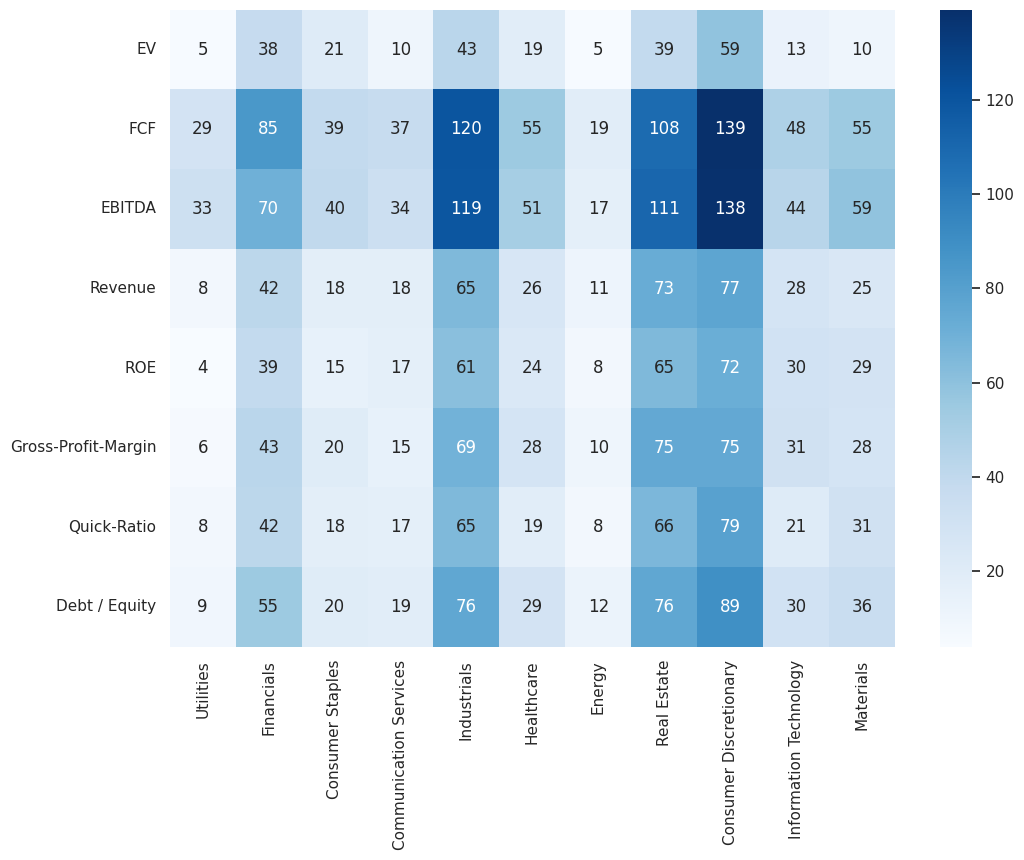

In [71]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(test,annot=True, cmap='Blues', fmt='.3g')

In [ ]:
test_merge.loc[test_merge.columns == 'Real Estate']

In [72]:
test_merge.loc[test_merge['Sector'] == 'Financials']

,Ticker,Name,Sector,Industry,Industry Group,Market Cap,Last Reported Fiscal Year,EV,EV FQ-1,EV FQ-2,...,Debt / Equity FQ-3,Debt / Equity FQ-4,Debt / Equity FQ-5,Debt / Equity FQ-6,Debt / Equity FQ-7,Debt / Equity FQ-8,Debt / Equity FQ-9,Debt / Equity FQ-10,Debt / Equity FQ-11,Debt / Equity FQ-12
4,335,Upbest Group Limited,Financials,Consumer Finance,Diversified Financials,205 M,2023,-,nan,nan,...,8.6%,9.4%,9.4%,9.9%,9.9%,10.4%,10.4%,10.8%,10.8%,11.2%
15,1469,Get Nice Financial Group Limited,Financials,Capital Markets,Diversified Financials,207 M,2023,-,nan,nan,...,0.3%,0.4%,0.4%,0.1%,0.1%,16.0%,16.0%,0.0%,0.0%,11.5%
18,1468,Kingkey Financial International (Holdings) Lim...,Financials,Capital Markets,Diversified Financials,1.554 B,2023,1.582 B,500.1 M,502.8 M,...,33.6%,32.5%,32.5%,63.7%,63.7%,49.4%,49.4%,40.4%,40.4%,26.3%
34,985,CST Group Limited,Financials,Capital Markets,Diversified Financials,107.8 M,2023,286.7 M,333.7 M,254.6 M,...,160.2%,160.3%,160.3%,64.7%,64.7%,99.9%,99.9%,124.8%,124.8%,77.1%
46,1428,Bright Smart Securities & Commodities Group Li...,Financials,Capital Markets,Diversified Financials,296.2 M,2023,-,nan,nan,...,213.1%,347.4%,347.4%,539.9%,539.9%,"1,413.6%","1,413.6%",167.1%,167.1%,114.5%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
849,3328,"Bank of Communications Co., Ltd.",Financials,Banks,Banks,47.273 B,2022,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
851,863,BC Technology Group Limited,Financials,Capital Markets,Diversified Financials,145.2 M,2022,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
865,1299,AIA Group Limited,Financials,Insurance,Insurance,120.7 B,2022,NaN,NaN,NaN,...,32.4%,19.6%,19.6%,22.7%,22.7%,17.5%,17.5%,16.5%,16.5%,15.1%
868,2003,VCREDIT Holdings Limited,Financials,Consumer Finance,Diversified Financials,157.6 M,2022,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
